In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-cats-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F22535%2F28903%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T015908Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0fc29988d0bed8c083d5db1eaaff79a544afceff99bbaaa97f86d729ad77a8ed58c88ea5c8c90dad1dfde1348b588223e03b80f33e16641ce202e3c8b428d95ac72dcadb836afe822600a94b2ddc1d51ba95fcaeadfbc442b2d99c22f203bce6851d0acdf24a44f026b42cf73a19eabefcd70ee836feef4c32bd5966cc692c26eedf77cc084ed30cc229843c75147e232fb7498e0481359e6231a34031b7c2b8168ab44e726339277a521f53037033f8f2c6e101c974cb702d3b3a3efd6bf486615bc027dc774d475873da55f28ff4f2850ca68b797e311f4e6c946c2235309bab94fa18f50cd00e37b234a6ba87abe20886b81d43626ff097a6bd5af6648947'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 455718914 bytes downloaded
Downloaded and uncompressed: dogs-cats-images
Data source import complete.


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile

In [3]:
# importing libraries for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
test_dir="../input/dogs-cats-images/dog vs cat/dataset/test_set"
train_dir="../input/dogs-cats-images/dog vs cat/dataset/training_set"

train_dir_cats = train_dir + '/cats'
train_dir_dogs = train_dir + '/dogs'
test_dir_cats = test_dir + '/cats'
test_dir_dogs = test_dir + '/dogs'

In [5]:
print('number of cats training images - ',len(os.listdir(train_dir_cats)))
print('number of dogs training images - ',len(os.listdir(train_dir_dogs)))
print('number of cats testing images - ',len(os.listdir(test_dir_cats)))
print('number of dogs testing images - ',len(os.listdir(test_dir_dogs)))

number of cats training images -  4000
number of dogs training images -  4000
number of cats testing images -  1000
number of dogs testing images -  1000


In [6]:
data_generator = ImageDataGenerator(rescale = 1.0/255.0, zoom_range = 0.2)

In [7]:
batch_size = 32
training_data = data_generator.flow_from_directory(directory = train_dir,
                                                   target_size = (64, 64),
                                                   batch_size = batch_size,
                                                   class_mode = 'binary')
testing_data = data_generator.flow_from_directory(directory = test_dir,
                                                  target_size = (64, 64),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
# preparing the layers in the Convolutional Deep Neural Network
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = training_data.image_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.3))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
model.add(Conv2D(filters = 126, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.15))
model.add(Flatten())
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = len(set(training_data.classes)), activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [15]:
fitted_model = model.fit_generator(training_data,
                        steps_per_epoch = 100,
                        epochs = 50,
                        validation_data = testing_data,
                        validation_steps = 1000)

<ipython-input-15-424c34af333c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = model.fit_generator(training_data,


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6016

100/100 [==============================] - 39s 386ms/step - loss: 0.6593 - accuracy: 0.6016 - val_loss: 0.6550 - val_accuracy: 0.6115
Epoch 2/50
100/100 [==============================] - 30s 299ms/step - loss: 0.6505 - accuracy: 0.6203
Epoch 3/50
100/100 [==============================] - 29s 287ms/step - loss: 0.6170 - accuracy: 0.6534
Epoch 4/50
100/100 [==============================] - 29s 285ms/step - loss: 0.6158 - accuracy: 0.6656
Epoch 5/50
100/100 [==============================] - 29s 294ms/step - loss: 0.5937 - accuracy: 0.6744
Epoch 6/50
100/100 [==============================] - 31s 306ms/step - loss: 0.5842 - accuracy: 0.6834
Epoch 7/50
100/100 [==============================] - 28s 284ms/step - loss: 0.5700 - accuracy: 0.6888
Epoch 8/50
100/100 [==============================] - 29s 285ms/step - loss: 0.5484 - accuracy: 0.7141
Epoch 9/50
100/100 [==============================] - 28s 284ms/step - loss: 0.5519 - accuracy: 0.7194
Epoch 10/50
100/100 [=====================

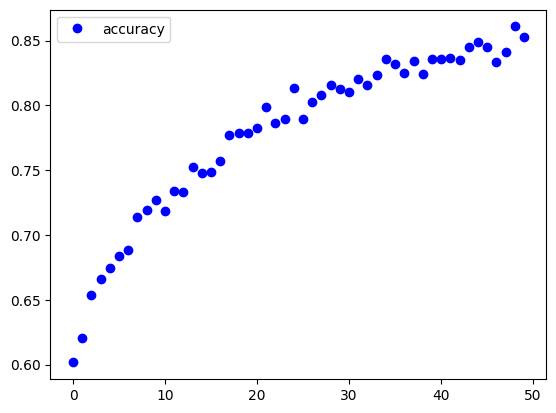

In [16]:
# plotting accuracy and validation accuracy
accuracy = fitted_model.history['accuracy']
plt.plot(range(len(accuracy)), accuracy, 'bo', label = 'accuracy')
plt.legend()